Naive Bayes for vote prediction

Gregory Wert | gaw8pa

In [1]:
# Data processing and functions
import pandas as pd
import numpy as np
import scipy as sp

# Analytics and modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Graphing and visualizing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from pylab import savefig


# Setting graphing preferences
sns.set(style="darkgrid", color_codes=True)

# Printing
import locale

# Show plots locally
locale.setlocale( locale.LC_ALL, '' )

%matplotlib inline

## Pre-Processing

### Reading in the Data

In [2]:
# read in the data
df = pd.read_csv('house-votes-84.data',header=None, na_values='?')

In [3]:
# rename the columns, make a list of the columns that correspond to votes
votes = ['handicapped-infants','water-project-cost-sharing','adoption-of-the-budget-resolution','physician-fee-freeze','el-salvador-aid','religious-groups-in-schools','anti-satellite-test-ban','aid-to-nicaraguan-contras','mx-missile','immigration','synfuels-corporation-cutback','education-spending','superfund-right-to-sue','crime','duty-free-exports','export-administration-act-south-africa']
df.columns = ['party','handicapped-infants','water-project-cost-sharing','adoption-of-the-budget-resolution','physician-fee-freeze','el-salvador-aid','religious-groups-in-schools','anti-satellite-test-ban','aid-to-nicaraguan-contras','mx-missile','immigration','synfuels-corporation-cutback','education-spending','superfund-right-to-sue','crime','duty-free-exports','export-administration-act-south-africa']

In [4]:
df.shape

(435, 17)

In [5]:
df.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


### transforming the variables

In [6]:
# function to replace y/n with 1/0
def binom_convert(v,one,zero):
    def binom_switch(x,one,zero):
        if x == one:
            return 1
        elif x == zero:
            return 0
        else: return x
    return v.apply(lambda x: binom_switch(x,one,zero))

In [7]:
# replace values
df = df.apply(lambda x: binom_convert(x, one='y', zero='n'))
df = df.apply(lambda x: binom_convert(x, one='democrat', zero='republican'))

In [8]:
df.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,1,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,1,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [9]:
# look at empty values
for x in df.columns:
    e = sum(df[x].isnull())
    p = round(100*e/len(df[x]))
    print(x+' :',e,': '+str(p)+'%')

party : 0 : 0.0%
handicapped-infants : 12 : 3.0%
water-project-cost-sharing : 48 : 11.0%
adoption-of-the-budget-resolution : 11 : 3.0%
physician-fee-freeze : 11 : 3.0%
el-salvador-aid : 15 : 3.0%
religious-groups-in-schools : 11 : 3.0%
anti-satellite-test-ban : 14 : 3.0%
aid-to-nicaraguan-contras : 15 : 3.0%
mx-missile : 22 : 5.0%
immigration : 7 : 2.0%
synfuels-corporation-cutback : 21 : 5.0%
education-spending : 31 : 7.0%
superfund-right-to-sue : 25 : 6.0%
crime : 17 : 4.0%
duty-free-exports : 28 : 6.0%
export-administration-act-south-africa : 104 : 24.0%


### Filling missing values

In [10]:
# This class imputes the missing values as
# (1) most frequent if the variable is categorical 
# (2) mean if the variable is real (floating point)
# (3) median if the variable is an integer 

# Here is a class that will provide imputation
# This is an extension by D.Brown to sveitser, 2014 https://stackoverflow.com/users/469992/sveitser

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.
        
        Columns of dtype floating point are imputed with the mean.

        Columns of other types are imputed with median of the column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') 
                               else X[c].mean() if X[c].dtype == np.dtype('f')
                                else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [11]:
# impute
df = DataFrameImputer().fit_transform(df)

## Exploration

### Correlation

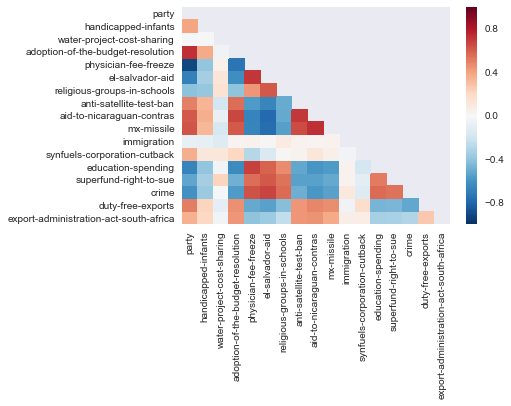

In [12]:
# heatmap
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask)
savefig('heat.png',bbox_inches='tight')

### T-SNE

In [26]:
# Get two components for plotting
components = 2

tsne = TSNE(n_components= components, init='random', perplexity =100,
                         random_state=42)

df_tsne = tsne.fit_transform(df)

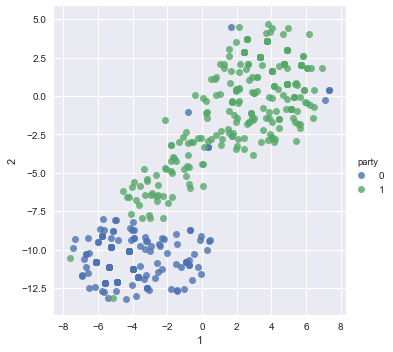

In [27]:
# plot
sns.lmplot('1', '2', data=pd.DataFrame(data={'1':df_tsne[:,0],'2':df_tsne[:,1],'party':df.party}),
           hue='party',
           #palette=dict(republican="darkred", democrat="darkblue"),
           fit_reg = False)
savefig('tsne.png',bbox_inches='tight')
plt.show()

### PCA

In [15]:
############
## perform PCA on the response variables

n = len(df.columns)

pca = PCA(n_components = n)
# default is the number of columns in the data 
# but can be set to any integer less than or equal to that value

df_pca = pca.fit_transform(df)

# Percentage of variance explained by the first two components

percent_explained = pca.explained_variance_ratio_[:2].sum()*100

print('Percent of explained variance (first two components): %0.0f'
      % percent_explained)


df_pca.shape

Percent of explained variance (first two components): 56


(435, 17)

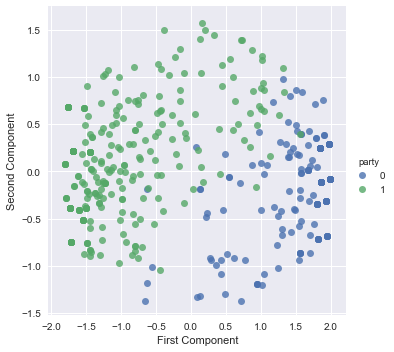

In [16]:
sns.lmplot('First Component', 'Second Component',
           data=pd.DataFrame(data={'First Component':df_pca[:,0],'Second Component':df_pca[:,1],
                                   'party':df.party}),
           hue='party',
           #palette=dict(republican="darkred", democrat="darkblue"),
           fit_reg = False,)
savefig('pca.png',bbox_inches='tight')
plt.show()

### Partisanship

In [17]:
# how each party voted towards the variable
def partisan_vote(x):
    tot = round(len(x[x == 1])/len(df), 2)
    dem = round(len(x[(df['party'] == 1) &( x == 1)])/len(df[df['party'] == 1]), 2)
    rep = round(len(x[(df['party'] == 0) &( x == 1)])/len(df[df['party'] == 0]), 2)
    return 'T : '+str(tot) + '| D : ' + str(dem) +  '| R : ' + str(rep)

In [18]:
df[votes].apply(lambda x: partisan_vote(x))

handicapped-infants                       T : 0.43| D : 0.58| R : 0.18
water-project-cost-sharing                T : 0.56| D : 0.55| R : 0.57
adoption-of-the-budget-resolution         T : 0.61| D : 0.89| R : 0.15
physician-fee-freeze                      T : 0.41| D : 0.05| R : 0.97
el-salvador-aid                           T : 0.52| D : 0.25| R : 0.95
religious-groups-in-schools                T : 0.65| D : 0.49| R : 0.9
anti-satellite-test-ban                   T : 0.58| D : 0.78| R : 0.27
aid-to-nicaraguan-contras                 T : 0.59| D : 0.83| R : 0.21
mx-missile                                T : 0.53| D : 0.78| R : 0.13
immigration                               T : 0.51| D : 0.48| R : 0.57
synfuels-corporation-cutback              T : 0.34| D : 0.48| R : 0.12
education-spending                         T : 0.39| D : 0.13| R : 0.8
superfund-right-to-sue                    T : 0.54| D : 0.33| R : 0.87
crime                                     T : 0.61| D : 0.37| R : 0.98
duty-f

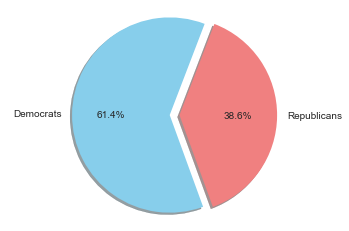

In [19]:
plt.pie([len(df.party)-sum(df.party),sum(df.party)],
        labels=['Republicans','Democrats'],
        colors=['lightcoral','skyblue'],
        autopct='%1.1f%%',
        shadow=True,
        explode=[.1,0],
        startangle=-70)

plt.axis('equal')
savefig('pie.png',bbox_inches='tight')
plt.show()

## Models


In [20]:
# functions used later, they detect party based votes
# percent of democrats
def dem_votes(x,y):
    tot = len(y)
    dem = len(x[x['party'] == 1])
    return (dem/tot)
# percent of party X members that voted yes
def party_y(x,y,party):
    d = pd.concat([x,y], axis=1)
    tot = len(y)
    dem = len(d[(d['party'] == party) & (d[y.name] == 1)])
    return (dem/tot)

In [21]:
# Function where you pick your type of model and priors if Naive Bayes
# returns the fitted model, the y prediction,the cv predicted,accuracy score,....
# ...., classification report, auc, fpr, tpr, and thresholdas
def Model(df,response,model=['NB','LR','LD','KNN','RF','MB'],priors=[False,'Partisan','D','R','GS']):
    # Pick response and dependent variables
    X = df.drop([response], axis = 1)
    y = df[response]
    # generate train/test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=44)
    #initialize model with designated priors
    if (priors=='Partisan') & (model=='NB'):
        if response == 'party':
            m = BernoulliNB()
        else: m = BernoulliNB(class_prior=[1-dem_votes(X_train,y_train),dem_votes(X_train,y_train)])
    elif (priors == 'D') & (model=='NB') :
        m = BernoulliNB(class_prior=[1-party_y(X_train,y_train,1),party_y(X_train,y_train,1)])
    elif (priors == 'R') & (model=='NB'):
        m = BernoulliNB(class_prior=[1-party_y(X_train,y_train,0),party_y(X_train,y_train,0)])
    elif (priors == 'GS') & (model=='NB'):
        priors = [[.05,90],[.1,.9],[.2,.8],[.3,.7],[.4,.6],[.5,.5],[.6,.4],[.7,.3],[.8,.2],[.9,.1],[.95,.05]]
        grid_hp = [{'class_prior': priors}]
        bnbGS = BernoulliNB()
        bnbGS.fit(X_train, y_train)
        grid_search = GridSearchCV(bnbGS, grid_hp, cv = 5)
        grid_search.fit(X_train, y_train)
        #Selected parameter values
        GSprior = grid_search.best_params_.get('class_prior')
        m = BernoulliNB(class_prior=GSprior)
    elif model=='NB':
        m = BernoulliNB()
    elif model == 'LR':
        m = linear_model.LogisticRegression()
    elif model == 'LD':
        m = LinearDiscriminantAnalysis()
    elif model == 'KNN':
        m = KNeighborsClassifier()
    elif model == 'RF':
        m = RandomForestClassifier()
    else: return 'Error'
    m.fit(X_train,y_train)
    # Fit the model and evaluate
    y_pred = m.predict_proba(X_test)
    # Cross Validation
    cv_predicted = cross_val_predict(m, X_train, y_train, cv=10)
    accuracyScore = accuracy_score(y_train, cv_predicted)
    classificationReport = classification_report(y_train, cv_predicted)
    # Get the predicted probabilities and the FPR and TPR
    y_pred = m.predict_proba(X_test)
    y_pred = y_pred[:,1]
    auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    return(pd.Series(data= [m,y_pred,cv_predicted,accuracyScore,classificationReport,
                            auc,fpr,tpr,thresholds],
                     index= ['m','y_pred','cv_predicted','accuracyScore',
                             'classificationReport','auc','fpr','tpr','thresholds']))
        

### Naive Bayes

In [22]:
# constrain the number of variables
# df= df.loc[:,'party':'el-salvador-aid'] # limited number


#### Automatically fit priors

In [23]:
bnb = df.apply(lambda x: Model(df, model='NB', response=x.name))

#### Partisan vote

In [24]:
#fit  priors to the partisan break down
bnbParty = df.apply(lambda x: Model(df, response=x.name, model='NB', priors='Partisan'))

#### Democrat Vote

In [25]:
#fit  priors to the partisan break down
bnbD = df.apply(lambda x: Model(df, response=x.name, model='NB', priors='D'))

#### Republican Vote

In [26]:
#fit  priors to the partisan break down
bnbR = df.apply(lambda x: Model(df, response=x.name, model='NB', priors='R'))

C:\Users\Grego\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:458: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = np.log(class_prior)
C:\Users\Grego\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:458: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = np.log(class_prior)
C:\Users\Grego\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:458: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = np.log(class_prior)
C:\Users\Grego\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:458: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = np.log(class_prior)
C:\Users\Grego\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:458: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = np.log(class_prior)
C:\Users\Grego\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:458: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = np.log(class_prior

#### GridSearch Optimized

In [27]:
#fit  priors to the partisan break down
bnbGS = df.apply(lambda x: Model(df, response=x.name, model='NB', priors='GS'))

### Logistic Regression

In [28]:
log_reg = df.apply(lambda x: Model(df,model='LR',response=x.name))

### LDA

In [29]:
ld = df.apply(lambda x: Model(df,model='LD',response=x.name))

### KNN

In [30]:
knn = df.apply(lambda x: Model(df,model='KNN',response=x.name))

### Random Forests

In [31]:
rf = df.apply(lambda x: Model(df,model='RF',response=x.name))

## Evaluation

### Accuracy

In [32]:
# Join model Accuracy Scores
modelsAccuracy = pd.DataFrame(data= {'Automatic':bnb.transpose().accuracyScore,
                    'Partisan':bnbParty.transpose().accuracyScore,
                    'Democrat':bnbD.transpose().accuracyScore,
                    'Repubican':bnbR.transpose().accuracyScore,
                    'GridSearch':bnbGS.transpose().accuracyScore,
                    'Logistic Reg':log_reg.transpose().accuracyScore,
                    'Linear Discr.':ld.transpose().accuracyScore,
                    'KNN':knn.transpose().accuracyScore,
                    'RF':rf.transpose().accuracyScore})

In [33]:
# find the maximizing model
topAcc = pd.DataFrame(data={'Top Performer':modelsAccuracy.idxmax(axis=1),'Accuracy':modelsAccuracy.max(axis=1)})
topAcc

,Accuracy,Top Performer
party,0.950920,Logistic Reg
handicapped-infants,0.726994,Linear Discr.
water-project-cost-sharing,0.650307,Linear Discr.
adoption-of-the-budget-resolution,0.877301,Logistic Reg
physician-fee-freeze,0.944785,Linear Discr.
el-salvador-aid,0.929448,Logistic Reg
religious-groups-in-schools,0.837423,GridSearch
anti-satellite-test-ban,0.868098,Logistic Reg
aid-to-nicaraguan-contras,0.886503,Linear Discr.
mx-missile,0.861963,Linear Discr.


In [34]:
# just the NB models
nbAcc = pd.DataFrame(data= {'Automatic':bnb.transpose().accuracyScore,
                    'Partisan':bnbParty.transpose().accuracyScore,
                    'Democrat':bnbD.transpose().accuracyScore,
                    'Repubican':bnbR.transpose().accuracyScore,
                    'GridSearch':bnbGS.transpose().accuracyScore})

In [35]:
# find the maximizing model
topNbAcc = pd.DataFrame(data={'Top Performer':nbAcc.idxmax(axis=1),'Accuracy':nbAcc.max(axis=1)})
topNbAcc

,Accuracy,Top Performer
party,0.892638,Automatic
handicapped-infants,0.720859,Partisan
water-project-cost-sharing,0.588957,GridSearch
adoption-of-the-budget-resolution,0.874233,GridSearch
physician-fee-freeze,0.923313,GridSearch
el-salvador-aid,0.926380,GridSearch
religious-groups-in-schools,0.837423,GridSearch
anti-satellite-test-ban,0.837423,GridSearch
aid-to-nicaraguan-contras,0.883436,GridSearch
mx-missile,0.855828,GridSearch


In [36]:
topNbAcc.Accuracy/topAcc.Accuracy

party                                     0.938710
handicapped-infants                       0.991561
water-project-cost-sharing                0.905660
adoption-of-the-budget-resolution         0.996503
physician-fee-freeze                      0.977273
el-salvador-aid                           0.996700
religious-groups-in-schools               1.000000
anti-satellite-test-ban                   0.964664
aid-to-nicaraguan-contras                 0.996540
mx-missile                                0.992883
immigration                               0.978261
synfuels-corporation-cutback              0.914027
education-spending                        1.000000
superfund-right-to-sue                    1.000000
crime                                     1.000000
duty-free-exports                         1.000000
export-administration-act-south-africa    0.978339
Name: Accuracy, dtype: float64

### AUC

In [37]:
# Join model AUC Scores
modelsAUC = pd.DataFrame(data= {'Automatic':bnb.transpose().auc,
                    'Partisan':bnbParty.transpose().auc,
                    'Democrat':bnbD.transpose().auc,
                    'Repubican':bnbR.transpose().auc,
                    'GridSearch':bnbGS.transpose().auc,
                    'Logistic Reg':log_reg.transpose().auc,
                    'Linear Discr.':ld.transpose().auc,
                    'KNN':knn.transpose().auc,
                    'RF':rf.transpose().auc})

In [38]:
# find the maximizing model
topAUC = pd.DataFrame(data={'Top Performer':modelsAUC.idxmax(axis=1),'AUC':modelsAUC.max(axis=1)})
topAUC

,AUC,Top Performer
party,0.999645,Linear Discr.
handicapped-infants,0.746032,Automatic
water-project-cost-sharing,0.672245,Logistic Reg
adoption-of-the-budget-resolution,0.968866,Linear Discr.
physician-fee-freeze,0.999295,Linear Discr.
el-salvador-aid,0.984848,Automatic
religious-groups-in-schools,0.905019,Logistic Reg
anti-satellite-test-ban,0.910243,Automatic
aid-to-nicaraguan-contras,0.980035,Logistic Reg
mx-missile,0.961590,Automatic


In [39]:
# NB only
nbAUC = pd.DataFrame(data= {'Automatic':bnb.transpose().auc,
                    'Partisan':bnbParty.transpose().auc,
                    'Democrat':bnbD.transpose().auc,
                    'Repubican':bnbR.transpose().auc,
                    'GridSearch':bnbGS.transpose().auc})

In [40]:
# find the maximizing model
topNbAUC = pd.DataFrame(data={'Top Performer':nbAUC.idxmax(axis=1),'AUC':nbAUC.max(axis=1)})
topNbAUC

,AUC,Top Performer
party,0.979389,Automatic
handicapped-infants,0.746032,Automatic
water-project-cost-sharing,0.599222,Automatic
adoption-of-the-budget-resolution,0.957005,Automatic
physician-fee-freeze,0.978858,Automatic
el-salvador-aid,0.984848,Automatic
religious-groups-in-schools,0.871042,Automatic
anti-satellite-test-ban,0.910243,Automatic
aid-to-nicaraguan-contras,0.975521,Automatic
mx-missile,0.961590,Automatic


In [41]:
topNbAUC.AUC/topAUC.AUC

party                                     0.979737
handicapped-infants                       1.000000
water-project-cost-sharing                0.891375
adoption-of-the-budget-resolution         0.987758
physician-fee-freeze                      0.979549
el-salvador-aid                           1.000000
religious-groups-in-schools               0.962457
anti-satellite-test-ban                   1.000000
aid-to-nicaraguan-contras                 0.995394
mx-missile                                1.000000
immigration                               0.879133
synfuels-corporation-cutback              0.760114
education-spending                        0.988263
superfund-right-to-sue                    0.964593
crime                                     0.998855
duty-free-exports                         1.000000
export-administration-act-south-africa    0.990737
Name: AUC, dtype: float64

In [42]:
# combined top AUC df
allTopAuc = pd.DataFrame(data={'Vote':topAUC.index.values,
                               'Top Model':topAUC['Top Performer'],
                               'Top AUC':topAUC['AUC'],
                               'Top NB':topNbAUC['Top Performer'],
                               'NB AUC':topNbAUC['AUC']})

### ROC

In [43]:
# join the fpr and tpr
modelsFpr = pd.DataFrame(data= {'Automatic':bnb.transpose().fpr,
                    'Partisan':bnbParty.transpose().fpr,
                    'Democrat':bnbD.transpose().fpr,
                    'Repubican':bnbR.transpose().fpr,
                    'GridSearch':bnbGS.transpose().fpr,
                    'Logistic Reg':log_reg.transpose().fpr,
                    'Linear Discr.':ld.transpose().fpr,
                    'KNN':knn.transpose().fpr,
                    'RF':rf.transpose().fpr})
modelsTpr = pd.DataFrame(data= {'Automatic':bnb.transpose().tpr,
                    'Partisan':bnbParty.transpose().tpr,
                    'Democrat':bnbD.transpose().tpr,
                    'Repubican':bnbR.transpose().tpr,
                    'GridSearch':bnbGS.transpose().tpr,
                    'Logistic Reg':log_reg.transpose().tpr,
                    'Linear Discr.':ld.transpose().tpr,
                    'KNN':knn.transpose().tpr,
                    'RF':rf.transpose().tpr})

In [44]:
# function to generate ROC curve with the best model and best NB
def ROCcomp(x,fpr,tpr):
    # get the top models specs
    main_fpr = fpr.loc[x['Vote'],x['Top Model']]
    main_tpr = tpr.loc[x['Vote'],x['Top Model']]
    main_auc = x['Top AUC']
    # get the top NB specs
    nb_fpr = fpr.loc[x['Vote'],x['Top NB']]
    nb_tpr = tpr.loc[x['Vote'],x['Top NB']]
    nb_auc = x['NB AUC']
    
    sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Arial',
            rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
    lw = 2
    plt.figure(figsize = [12,10])
    plt.plot(main_fpr, main_tpr, color='darkblue',
             lw=lw, label=x['Top Model']+' (AUC = %0.2f)' % main_auc)
    plt.plot(nb_fpr, nb_tpr, color='darkorange',
             lw=lw, label=x['Top NB']+' (AUC = %0.2f)' % nb_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: '+x['Vote'])
    plt.legend(loc="lower right")
    savefig(x['Vote']+'.png',bbox_inches='tight')
    plt.show()

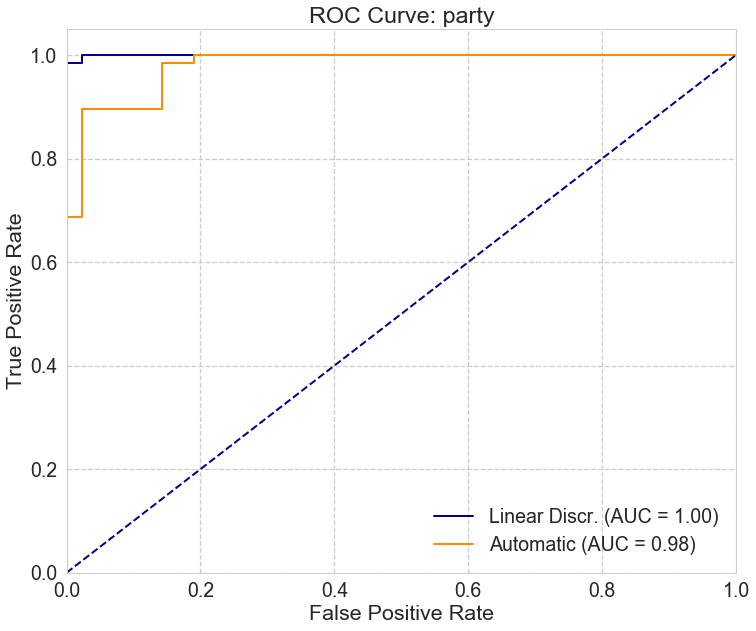

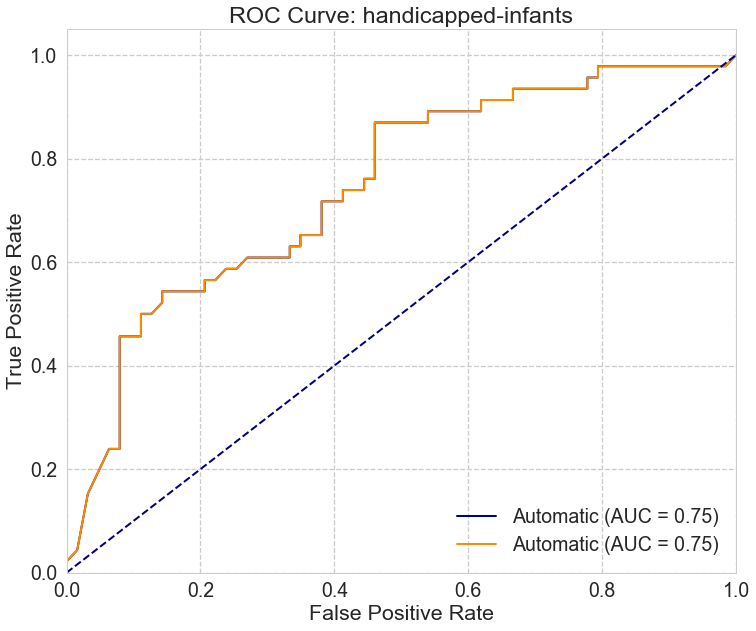

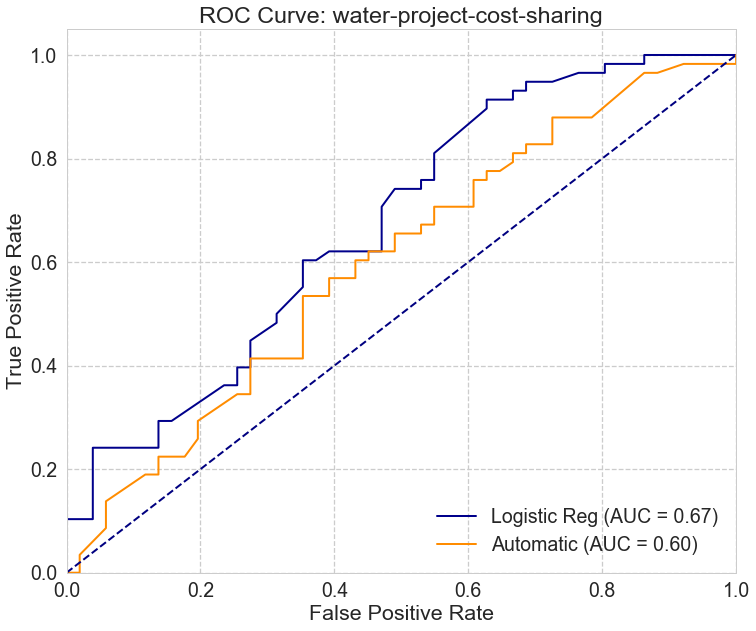

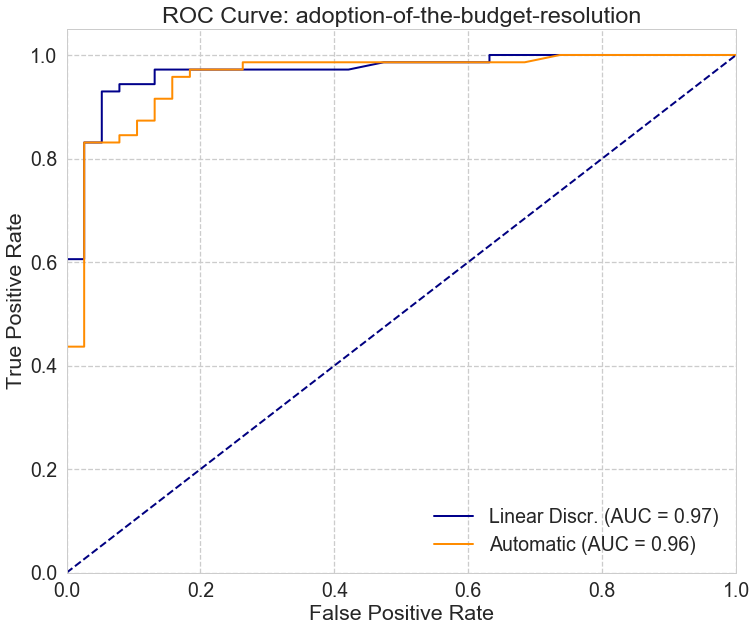

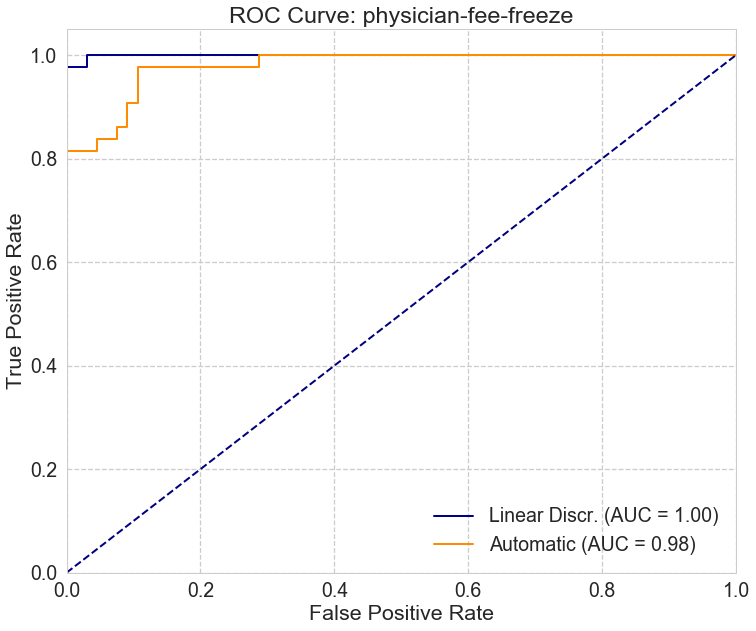

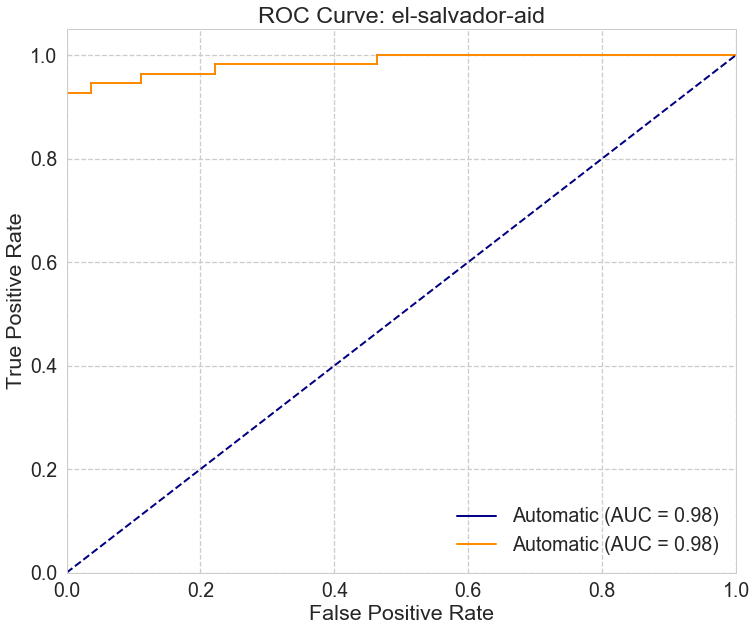

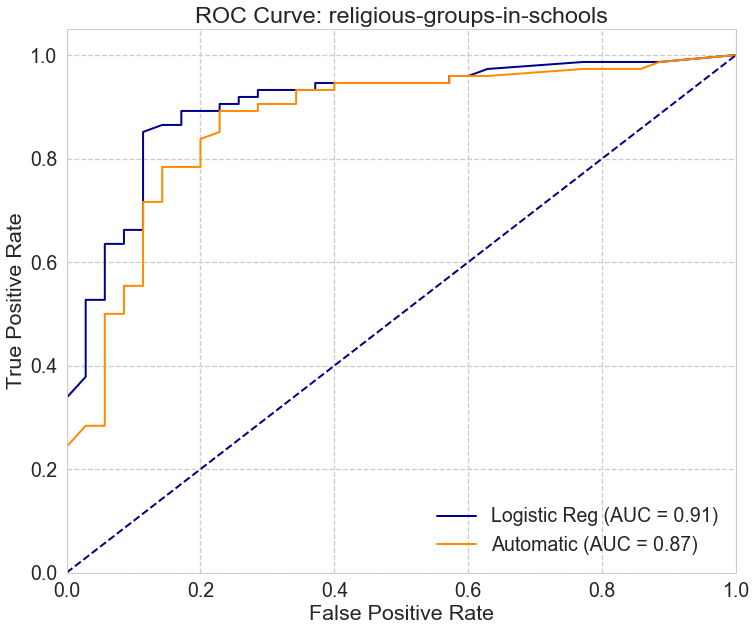

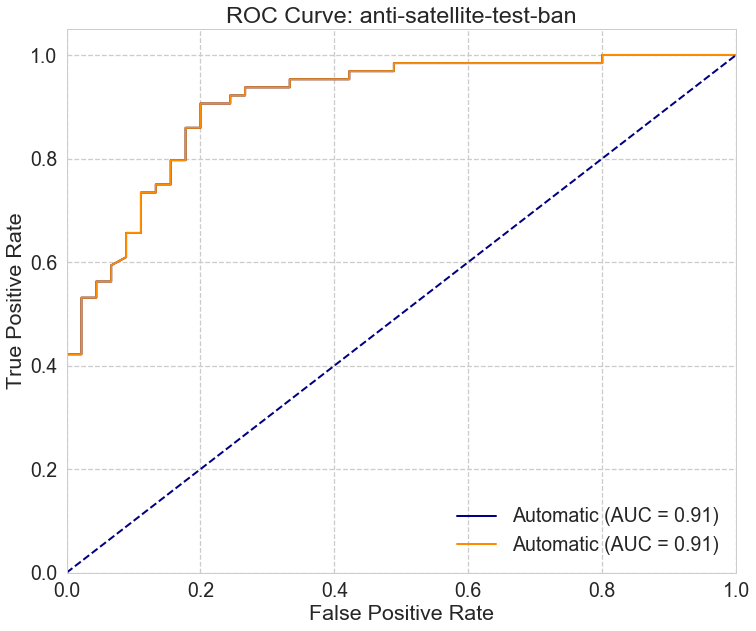

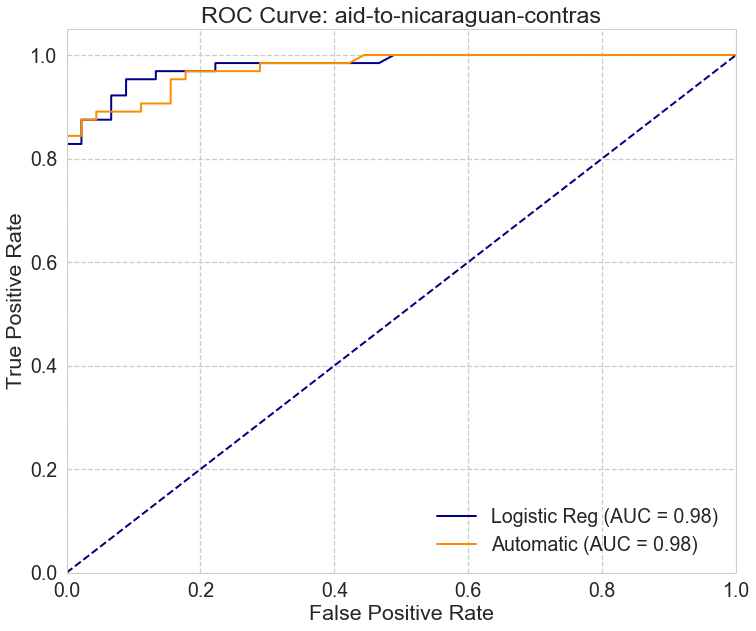

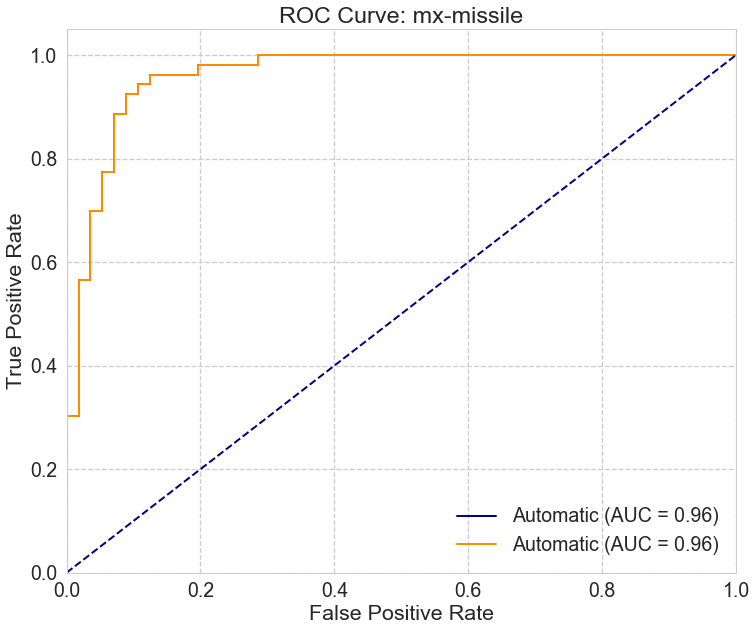

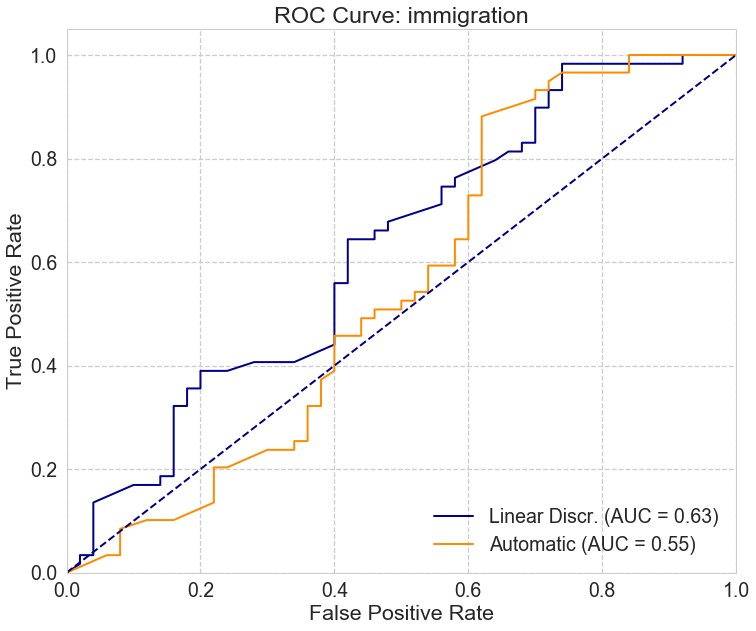

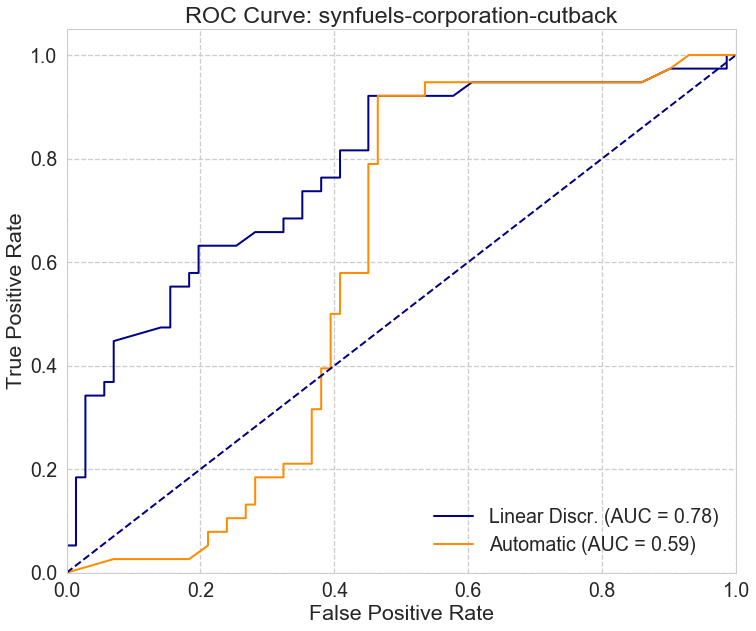

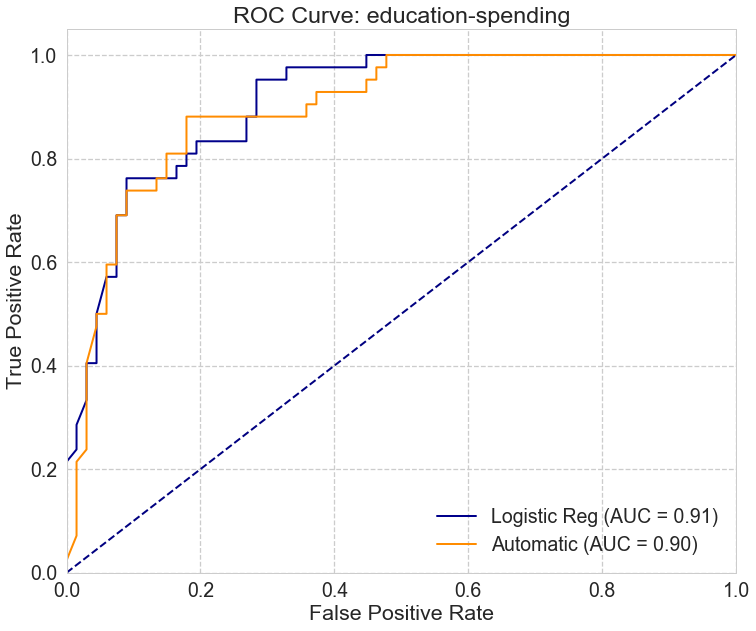

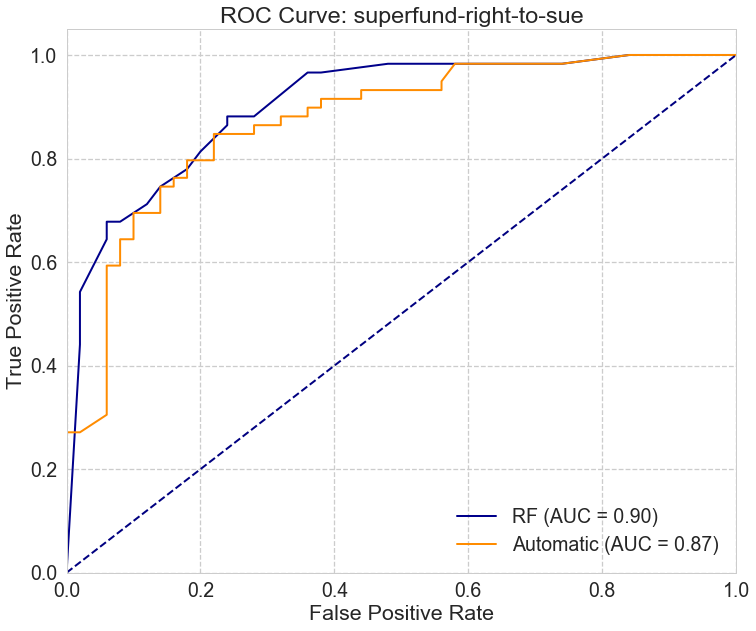

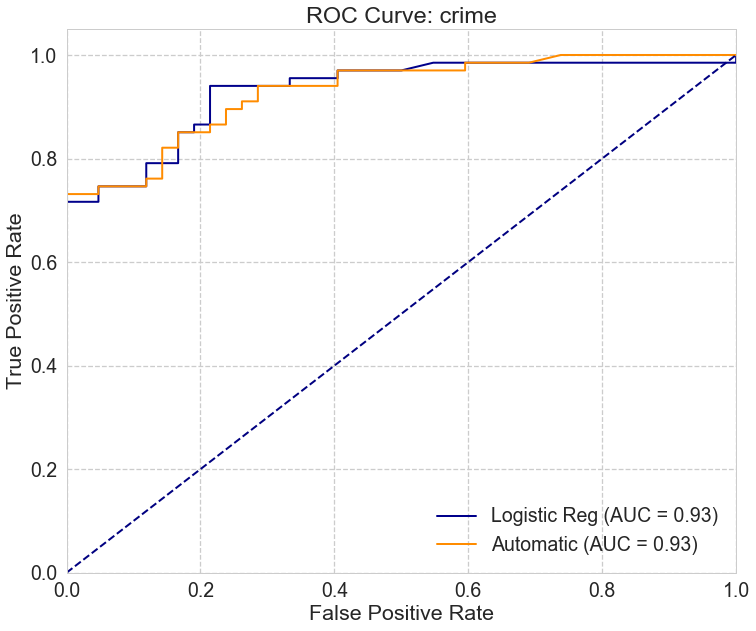

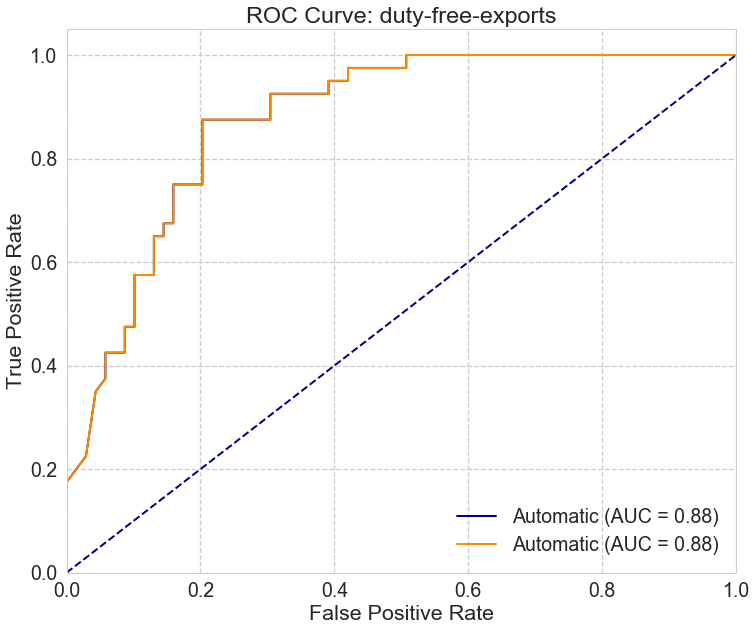

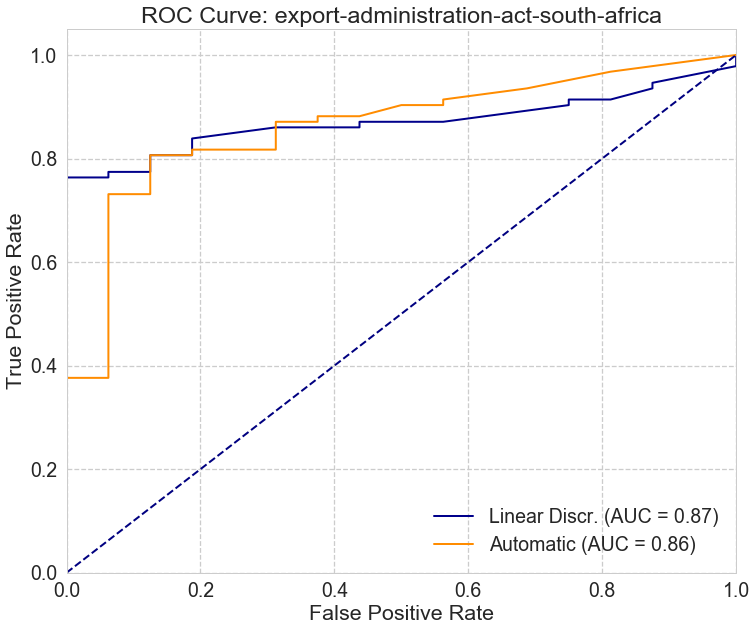

party                                     None
handicapped-infants                       None
water-project-cost-sharing                None
adoption-of-the-budget-resolution         None
physician-fee-freeze                      None
el-salvador-aid                           None
religious-groups-in-schools               None
anti-satellite-test-ban                   None
aid-to-nicaraguan-contras                 None
mx-missile                                None
immigration                               None
synfuels-corporation-cutback              None
education-spending                        None
superfund-right-to-sue                    None
crime                                     None
duty-free-exports                         None
export-administration-act-south-africa    None
dtype: object

In [45]:
allTopAuc.apply(lambda x: ROCcomp(x,fpr=modelsFpr,tpr=modelsTpr), axis=1)